In [1]:
import retinapy
import retinapy.spikeprediction as sp
import retinapy.mea as mea
import numpy as np
import torch
import pathlib
import matplotlib as mpl
import plotly
import plotly.graph_objects as go
import plotly.subplots as subplots
from collections import defaultdict
import retinapy.spikedistancefield as sdf
import torch.nn.functional as F
import scipy
import pathlib
import math
import torchinfo

In [2]:
stimulus_pattern_path = "../data/ff_noise.h5"
stimulus_rec_path = "../data/ff_recorded_noise.pickle"
response_path = "../data/ff_spike_response.pickle"
rec_name = "Chicken_17_08_21_Phase_00"

In [3]:
rec = mea.single_3brain_recording(
    rec_name,
    mea.load_stimulus_pattern(stimulus_pattern_path),
    mea.load_recorded_stimulus(stimulus_rec_path),
    mea.load_response(response_path),
    include_clusters={21},
)

In [4]:
torch.set_grad_enabled(False);

model_ckpt = "../out/exp/1/2/4/nonorm/0/DistFieldCnn-18ds_1586in/checkpoint_epoch-9.pth"
model_ckpt = "../out/exp/1/2/4/nonorm/lr_4/0/DistFieldCnn-18ds_1586in/checkpoint_best_pearson_corr-10_bins_epoch-24.pth"
model_ckpt = "../out/exp/1/2/4/nonorm/lr_4/1/DistFieldCnn-18ds_1586in/checkpoint_best_loss_epoch-97.pth"
model_ckpt = "../out/exp/1/2/4/nonorm/lowjitter&drop/lr_4/1/DistFieldCnn-18ds_1586in/checkpoint_best_loss_epoch-10.pth"
model_ckpt = "../out/exp/1/3/2/0/DistFieldCnn-18ds_1586in/checkpoint_best_loss_epoch-36.pth"
model_ckpt = "../out/exp/1/5/norm5_mindist0.5_offset_1.4/0/DistFieldCnn-18ds_1586in/checkpoint_epoch-3.pth"
model_ckpt = "../out/exp/1/5/norm10_mindist0.25_offset_neg0.5/1/DistFieldCnn-9ds_1984in/checkpoint_best_loss_epoch-21.pth"
model_ckpt = "../out/exp/1/6/6/DistFieldCnn-9ds_3174in/checkpoint_epoch-3.pth"
model_ckpt = "../out/exp/1/7/0/DistFieldCnn-9ds_3174in/checkpoint_epoch-24.pth"
model_ckpt = "../out/exp/1/7/0/DistFieldCnn-9ds_3174in/checkpoint_best_loss_epoch-63.pth"
model_ckpt = "../out/exp/1/7/0/DistFieldCnn-9ds_3174in/checkpoint_best_loss_epoch-78.pth"
# Above is old.
model_ckpt = "../out/exp/1/7/better_aug/0/DistFieldCnn-9ds_3174in/checkpoint_best_pearson_corr-50_bins_epoch-0.pth"
model_ckpt = "../out/exp/1/10/13/DistFieldCnn-9ds_3174in/checkpoint_best_loss_epoch-3.pth"
medel_ckpt = "../out/exp/1/10/13/DistFieldCnn-9ds_3174in/checkpoint_best_loss_epoch-16.pth"
medel_ckpt = "../out/exp/1/10/13/DistFieldCnn-9ds_3174in/checkpoint_epoch-99.pth"
assert pathlib.Path(model_ckpt).resolve().exists()

In [5]:
# Create datasets and model.
input_len = 1586
output_len = 200
downsample = 18
input_len = 3174
output_len = 398
downsample = 9
trainable = sp.DistFieldCnnTrainableGroup.create_trainable(rec, sp.Configuration(downsample, input_len, output_len))
model = trainable.model
test_ds = trainable.test_ds
train_ds = trainable.train_ds



In [6]:
torchinfo.summary(trainable.model, device='cpu', input_size=(1, 5, 3174+400))

Layer (type:depth-idx)                   Output Shape              Param #
DistanceFieldCnnModel                    [1, 400]                  --
├─Sequential: 1-1                        [1, 20, 1787]             --
│    └─Conv1d: 2-1                       [1, 20, 1787]             15,120
│    └─LeakyReLU: 2-2                    [1, 20, 1787]             --
│    └─Conv1d: 2-3                       [1, 20, 1787]             60,420
│    └─BatchNorm1d: 2-4                  [1, 20, 1787]             40
│    └─LeakyReLU: 2-5                    [1, 20, 1787]             --
├─Residual1dBlock: 1-2                   [1, 50, 1787]             --
│    └─Sequential: 2-6                   [1, 50, 1787]             --
│    │    └─Conv1d: 3-1                  [1, 50, 1787]             1,000
│    │    └─BatchNorm1d: 3-2             [1, 50, 1787]             100
│    └─Conv1d: 2-7                       [1, 50, 1787]             1,050
│    └─BatchNorm1d: 2-8                  [1, 50, 1787]             100

In [7]:
# Load model checkpoint.
#retinapy.models.load_model(model, model_ckpt)
ckpt_state = torch.load(model_ckpt, map_location=torch.device('cpu'))
model.load_state_dict(ckpt_state["model"]);
model.eval()

DistanceFieldCnnModel(
  (layer0): Sequential(
    (0): Conv1d(5, 20, kernel_size=(151,), stride=(2,), padding=(75,))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv1d(20, 20, kernel_size=(151,), stride=(1,), padding=(75,))
    (3): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer1): Residual1dBlock(
    (conv1): Conv1d(20, 50, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(50, 50, kernel_size=(7,), stride=(1,), padding=(3,))
    (conv3): Conv1d(50, 50, kernel_size=(1,), stride=(1,))
    (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut_downsample): Sequential(
      (0): Conv1d(20, 50, kernel_size=(1,), stride=(1,), bias=False)
      (1):

In [110]:
def pred_once_old(model, snippet):
    in_snippet = torch.Tensor(np.expand_dims(snippet, 0))
    model_out = model(in_snippet) * sp.DIST_NORM
    return np.squeeze(model_out.numpy())

def _pred_once(model, snippet):
    in_snippet = torch.Tensor(np.expand_dims(snippet, 0))
    model_out = model(in_snippet)
    #model_out = trainable.nn_output_to_distfield(model_out)
    return model_out

def pred_once(model, snippet):
    return np.squeeze(_pred_once(model, snippet).numpy())

def pred_rolling(model, in_samples):
    res_strided = []
    stride = 10
    eval_len = len(in_samples[0][-1])
    smooth_pred = np.zeros(eval_len)
    offset = 100
    for idx in range(0, len(in_samples), stride):
        pred = pred_once(model, in_samples[idx][0])
        smooth_pred[idx:] += pred[0:len(pred)-idx] 
        pred_short = pred[offset:offset+stride]
        res_strided.append(pred_short)
    #res = np.array(pred)
    norm = np.kron(np.arange(0, eval_len//stride)+1, np.ones((stride,)))
    smooth_pred /= norm
    res_strided = np.concatenate(res_strided)
    return smooth_pred, res_strided

def infer_num_spikes2(dist, eval_len, threshold, offset):
    scale = 0.75
    start = offset
    end = offset + eval_len
    tnum = torch.sum(dist[:,start:end] < threshold)/(threshold*scale)
    t2num = torch.sum(torch.logical_and(dist[:,start:end] < threshold*1.5, dist[:,start:end] > threshold))/(threshold*scale*2.0)
    if tnum > 0.3:
        res = tnum
    else:
        res = max(tnum, t2num)
    return res
    

def infer_num_spikes(dist, eval_len, threshold, offset):
    kernel = torch.FloatTensor(
        [[[0.25, 0.5, 0.25]]]
    ).to(dist.device)
    smoothed = torch.squeeze(F.conv1d(dist[None,...], kernel, padding=0))
    smoothed = smoothed[offset:eval_len+offset]
    above_threshold = (smoothed > threshold).float()
    transitions = (torch.diff(above_threshold, 1, dim=0) < 0)
    return torch.sum(transitions).item()


def infer_num_spikes3(dist, eval_len, threshold, offset):
    start = offset
    end = offset + eval_len
    kernel = torch.FloatTensor(
        [[[0.25, 0.5, 0.25]]]
    ).to(dist.device)
    smoothed = torch.squeeze(F.conv1d(dist[None,...], kernel, padding=0))
    smoothed = smoothed[start:end]
    above_threshold = (smoothed > threshold)
    #transitions = (torch.diff(above_threshold.float(), 1, dim=0) < 0)
    #transitions += (torch.diff((smoothed > 0).float(), 1, dim=0) < 0)
    down = torch.sum((torch.diff((smoothed > 0.3).float(), 1, dim=0) < 0)).item()
    up = torch.sum((torch.diff((smoothed < 0.3).float(), 1, dim=0) < 0)).item()
    _min = min(up, down)
    integral = torch.sum(~above_threshold).float() / (math.log(eval_len)*8)
    _max = eval_len / (3*2) # 6 per 10ms
    res = max(_min, min(_max, integral))
    return res


def infer_num_spikes4(dist, eval_len, threshold, offset):
    kernel = torch.FloatTensor(
        [[[0.006, 0.061, 0.242, 0.383, 0.242, 0.061, 0.006]]]
    ).to(dist.device)
    kernel_size = 7
    offset = offset - kernel_size // 2 # conv centers the array foward (when zero padding)
    smoothed = torch.squeeze(F.conv1d(dist[None,...], kernel, padding=0))
    smoothed = smoothed[offset:eval_len+offset]
    minima_list = scipy.signal.argrelextrema(smoothed.numpy(), np.less)
    minima = np.concatenate(minima_list)
    # Minima that are under the threshold.
    below_threshold = (smoothed < threshold).numpy()
    num_spikes = np.sum(below_threshold[minima])
    return num_spikes

def infer_num_spikes_spline(dist, eval_len, threshold, offset):
    #spline = scipy.interpolate.InterpolatedUnivariateSpline(x=xs,  y=dist, k=4)#s=smoothing)
    smoothing = 0.05
    dist = dist[0]
    xs = np.arange(len(dist))
    spline = scipy.interpolate.UnivariateSpline(x=xs,  y=dist, k=4, s=smoothing)
    roots_idxs = np.round(spline.derivative().roots()).astype(int)
    grad2_at_roots = spline.derivative().derivative()(roots_idxs)
    dist_at_roots = spline(roots_idxs)
    minima_idxs = roots_idxs[np.logical_and(grad2_at_roots > 0, 
                                            dist_at_roots < threshold)]
    minima = np.zeros_like(dist)
    minima[minima_idxs] = 1
    num_spikes = np.sum(minima[offset:offset+eval_len])
    return num_spikes
    
    
def stimulus_fig(stimulus):
    #'names':['Red', 'Green', 'UV', 'Blue', 'Stim'],
    colormap = ['#ff0a0a', '#0aff0a', '#0a0aff', '#303030', '#0a0a0a']
    fig = go.Figure()
    xs = -np.arange(stimulus.shape[1]) 
    for c in range(4):
        fig.add_trace(go.Scatter(x=xs, y=stimulus[c,:], line_color=colormap[c], 
                                 mode='lines'))
    fig.update_layout(autosize=False, height=400, width=800, showlegend=False)
    return fig
    

#print(infer_num_spikes(torch.Tensor([10,5,1,1,8,10,10,10,10,1,1,1,4,10]), eval_len=10, threshold=6))


def test_vl(model, eval_len, threshold, quick=False):
    targets = []
    predictions = []
    start = 100
    until = len(test_ds)//5 if quick else len(test_ds)
    for t in range(0, until, eval_len):
        snippet, spikes, dist = test_ds[t]
        model_out = _pred_once(model, snippet)
        num_spikes = np.sum(spikes[start:start+eval_len])
        pred_spikes = infer_num_spikes_spline(model_out, eval_len, threshold, start)
        #pred_spikes = infer_num_spikes3(model_out, eval_len, threshold, start)
        #pred = np.sum(np.diff(threshold_test, n=1))
        predictions.append(pred_spikes)
        targets.append(num_spikes)
    targets = np.array(targets)
    predictions = np.array(predictions)
    return targets, predictions

In [111]:
def get_example(i):
    s200 = [test_ds[i+j] for j in range(200)]
    snippet, target_spikes, dist = s200[0]
    pred_1 = pred_once(model, snippet)
    pred_smooth, pred_strided = pred_rolling(model, s200)
    return (snippet, pred_1, 
            pred_smooth, 
            pred_strided, 
            target_spikes, np.squeeze(dist))

In [112]:
def create_scatters(xs, model_out, dist, model_out_smooth=None, model_out_chunk=None, showlegend=False):
    assert model_out.shape == dist.shape
    assert len(model_out.shape) == 1, "Only support single sample (no batch)."
    res = []
    scatter_model = go.Scatter(x=xs, y=model_out, name='Pred', legendgroup='g1', 
                               line_color='gray',
                               showlegend=showlegend)
    res.append(scatter_model)
    if model_out_smooth is not None:
        scatter_model_r = go.Scatter(x=xs, y=model_out_smooth, name='Pred rolling', 
                                     line_color='darkblue',
                                     legendgroup='g2', showlegend=showlegend)
        res.append(scatter_model_r)
    if model_out_chunk is not None:
        scatter_model_c = go.Scatter(x=xs, y=model_out_chunk, name='Pred chucked', 
                                     line_color='orange',
                                     legendgroup='g2', showlegend=showlegend)
        res.append(scatter_model_c)
    scatter_y = go.Scatter(x=xs, y=dist, name='Actual', 
                           line_color='red',
                           legendgroup='g3', showlegend=showlegend)
    res.append(scatter_y)
    return res



def debug(bin_indicies):
    fig = subplots.make_subplots(rows=len(bin_indicies), cols=1, shared_xaxes=False, 
                                 vertical_spacing=0.01)
    for i,t in enumerate(bin_indicies):
        showlegend = (i == 0)
        snippet, _, dist = test_ds[t]
        pred = pred_once(model, snippet)
        start = t/2
        end = start + 200
        xs = np.arange(start, end, 0.5)
        scatters = create_scatters(xs, pred, 
            trainable.distfield_to_nn_output(torch.Tensor(dist)).numpy(), showlegend=showlegend)
        for scatr in scatters:
            fig.add_trace(scatr, row=i+1, col=1)
    fig.update_layout({
        "margin":{"l":0, "r":0, "t":0, "b":0, "pad":0},
        "autosize":False,
        "height":200*len(bin_indicies),
        "width":1000,
        #"yaxis_range":[0,150],
        "yaxis_fixedrange":False,
    })
    fig.update_yaxes(range=[-5,3])
    fig.show()

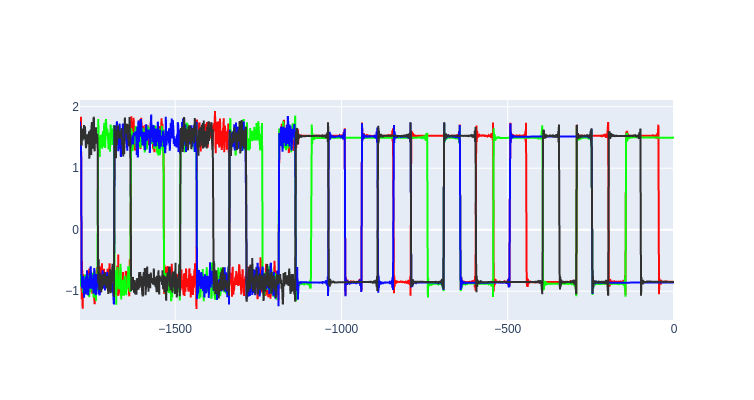

In [113]:
# Debug stimulus
train_stim = trainable.train_ds[9][0]
stimulus_fig(scipy.signal.decimate(train_stim, 2, axis=1)).show()

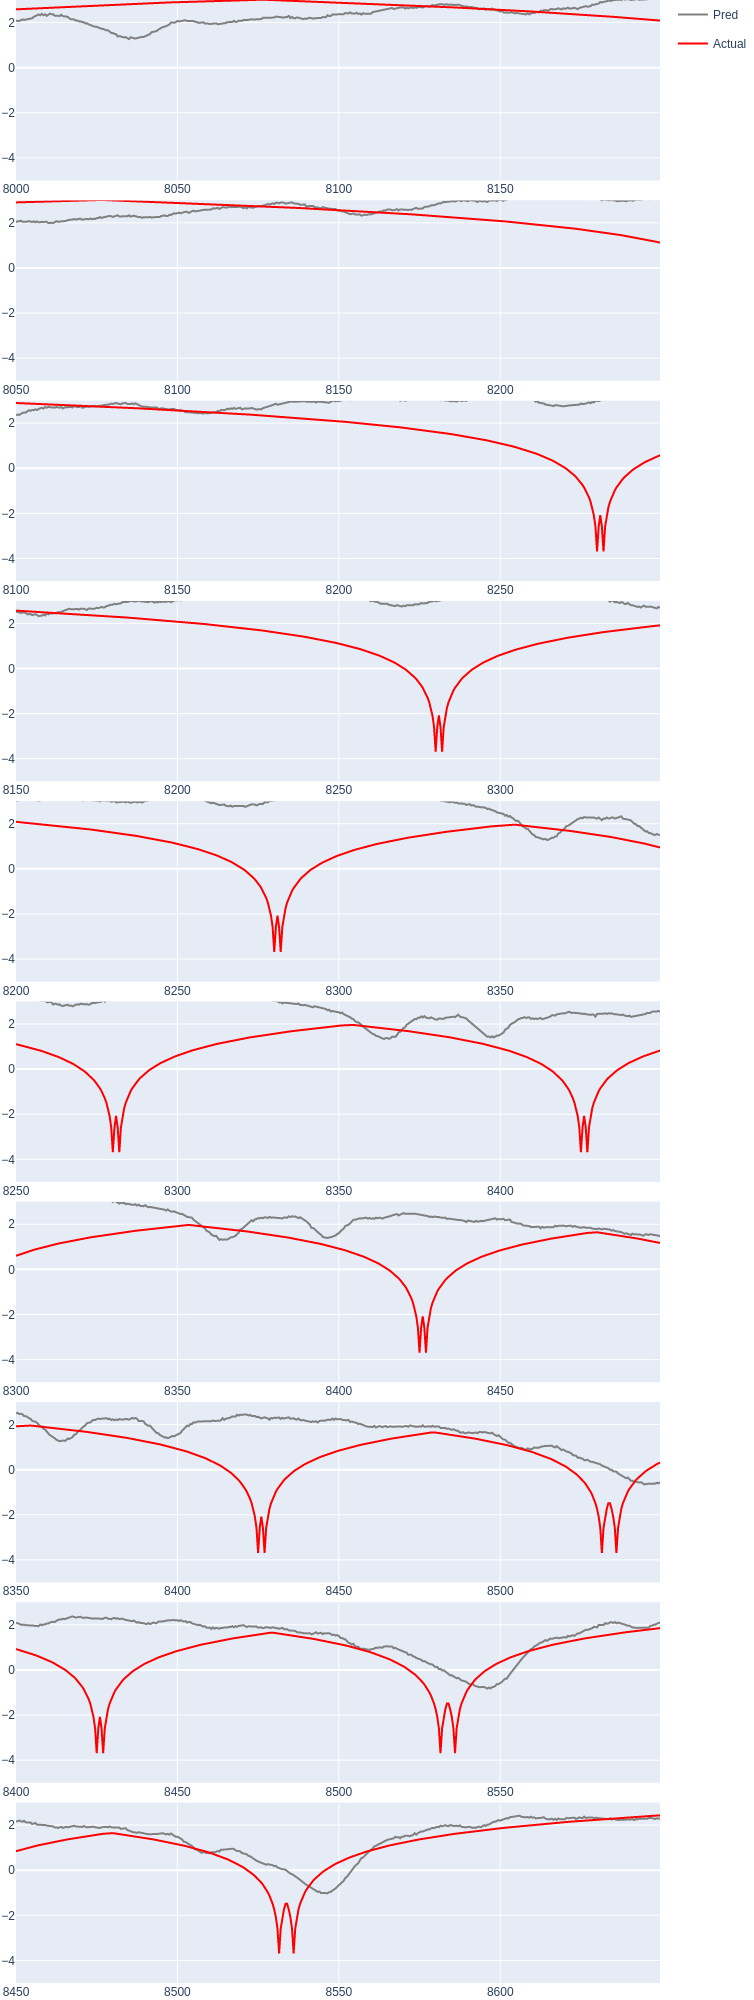

In [114]:
num_debug = 10
out_len = 400
step = out_len // 4
start = 1*num_debug*step
#start = 18000
start = 8000
debug(np.arange(num_debug)*step + start*2)

In [115]:
threshold = 0.7#31 # Eval=50, produces:(75, 47.5) @ 34t, (77,48) @ 30t, (78, 48.7) @ 28t, (82, 45) @ 20t
eval_len = 20
targets, predictions = test_vl(model, eval_len=eval_len, threshold=threshold, quick=True)

accuracy: 0.6121813031161473, pearson_corr: 0.41758048801247394


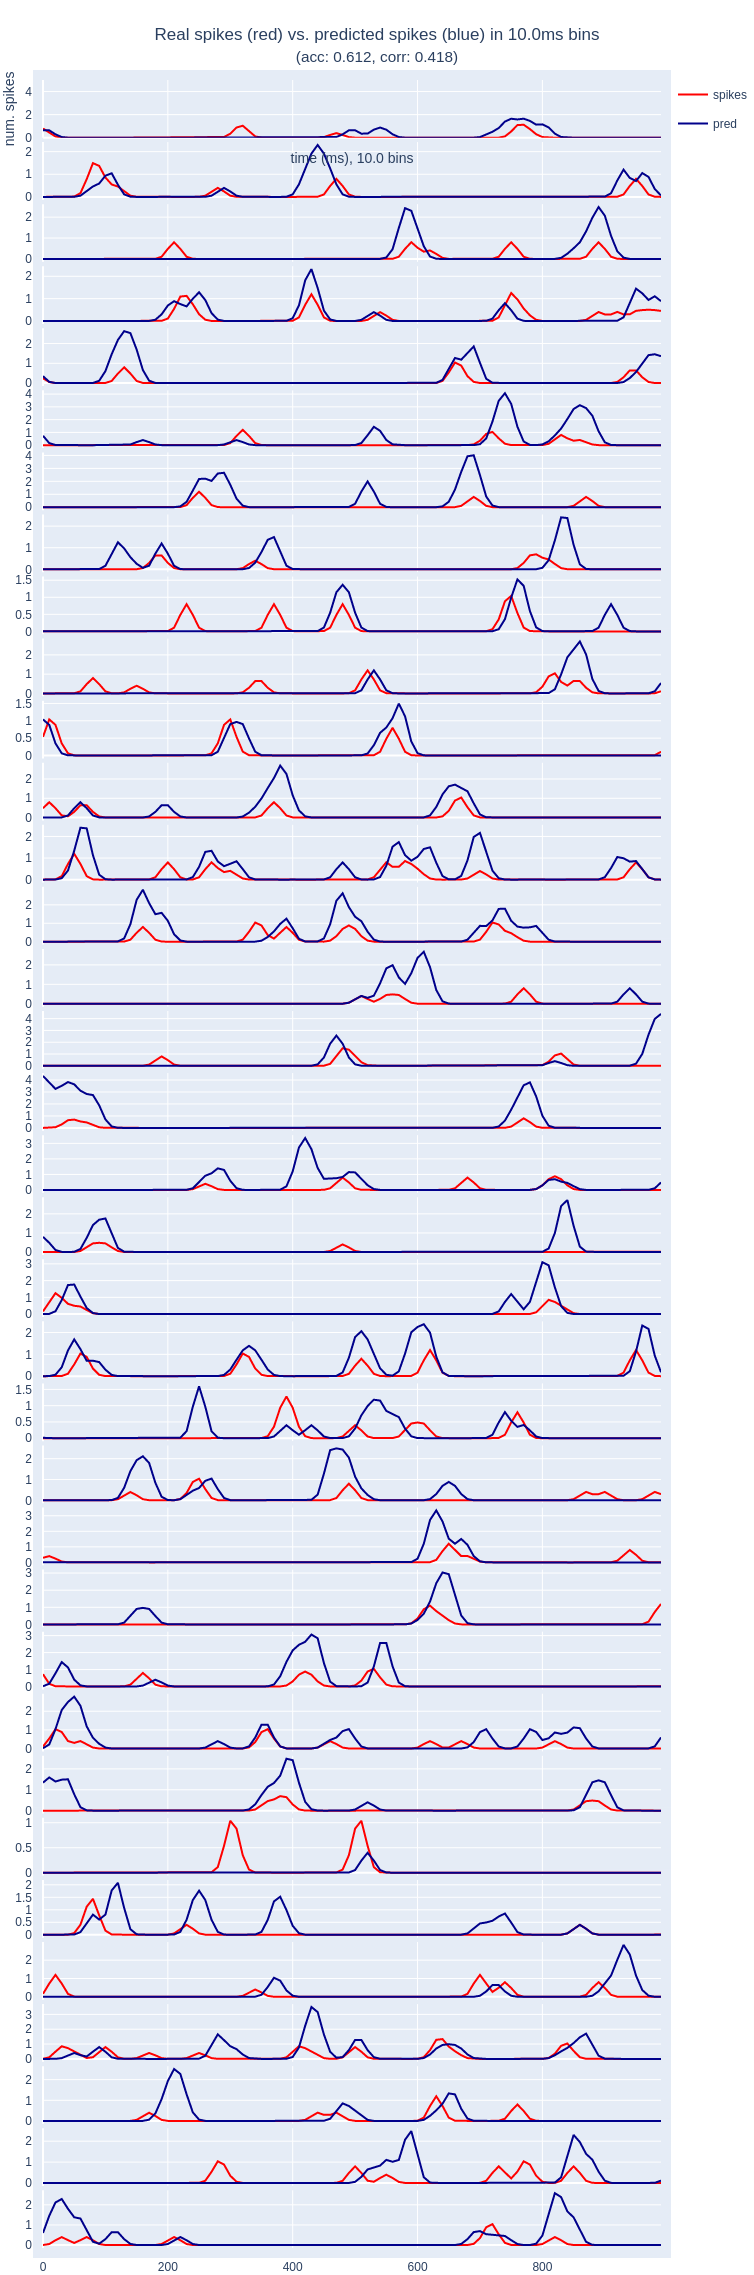

In [116]:
def do_stats(t, p, step_ms, chart_type="line"): 
    acc = np.mean(np.round(p) == t)
    pearson_corr = scipy.stats.pearsonr(p, t)[0]
    print(f"accuracy: {acc}, pearson_corr: {pearson_corr}")
    plot_w = 100
    num_plots = max(len(t) // plot_w, 1)
    fig = subplots.make_subplots(rows=num_plots, cols=1, shared_xaxes=True, vertical_spacing=0.002)
    for i in range(0, num_plots):
        xs = np.arange(0, plot_w) * (step_ms)
        start, end = np.array([i, i+1]) * plot_w
        if chart_type not in {"dot", "line"}:
            raise ValueError(f"Only dot and line charts are supported. Got ({chart_type}).")
        mode = 'markers' if chart_type=='dot' else 'lines'
        marker_size = 4
        chart_spike = go.Scatter(x=xs, y=t[start:end], name="spikes", 
                                   line_color='red', mode=mode, marker={'size':marker_size},
                                   legendgroup='g1', showlegend=(i==0))
        chart_pred = go.Scatter(x=xs, y=p[start:end], name="pred",
                                  line_color='darkblue', mode=mode, marker={'size':marker_size},
                                  legendgroup='g2', showlegend=(i==0))
        fig.add_trace(chart_spike, row=i+1, col=1)
        fig.add_trace(chart_pred, row=i+1, col=1)
    fig.update_layout({
            "margin":{"l":0, "r":0, "t":80, "b":10, "pad":10},
            "autosize":False,
            "height":65*num_plots,
            "width":800,
            "yaxis_range":[0,5],
            "title":f"Real spikes (red) vs. predicted spikes (blue) in {step_ms}ms bins<br><span style='font-size:90%'>(acc: {acc:.3f}, corr: {pearson_corr:.3f})</span>",
            "title_x":0.5,
            "title_pad":dict(l=1, r=1, b=20, t=20),
            "xaxis":{'title':f'time (ms), {step_ms} bins', 'side':'bottom'},
            "yaxis":{'title':'num. spikes'} })
    return fig
fig = do_stats(
    scipy.ndimage.gaussian_filter1d(targets, sigma=1, axis=0, mode='constant', cval=0.0),
    scipy.ndimage.gaussian_filter1d(predictions, sigma=1, axis=0, mode='constant', cval=0.0),
                                    step_ms=eval_len/2, chart_type="line")
fig.show()

In [117]:
_dir =  pathlib.Path(model_ckpt).parent 
name = f'{pathlib.Path(model_ckpt).name}_threshold_{threshold}_evallen{eval_len}.png'
fig.write_image(_dir / name)
fig.write_image(f'../out/exp/imgcompare/{name}')